# 1 IMPORTS

In [44]:
import os
import sqlalchemy
import dotenv
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from scipy.stats           import kurtosis, skew,chi2_contingency
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

from sklearn               import model_selection as ms
from sklearn               import ensemble        as en

from IPython.display import Image

## 1.1 Helper Functions

In [2]:
def jupyter_settings():
    """
    sets up jupyter to prefered settings
    """
    
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.set_option('display.max_columns', None)
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set()
    
    return None

def postgres_con():
    """
    Connects to mariadb based on .env information
    """
    dotenv.load_dotenv( dotenv.find_dotenv() )
    
    username = os.getenv('USERNAME')
    password = os.getenv('PASSWORD_PA')
    host =     os.getenv('HOST')
    port =     os.getenv('PORT')    
    database = os.getenv('DATABASE')
    
    con = sqlalchemy.create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')
    
    return con

def cramer_v( x, y ):
    """
    Calculates the correlation between categorical variables, x and y are pandas series.
    """
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def freq_encoder( col ):
    col = col.copy()
    map_values = dict( col.groupby(col.columns[0]).size()/len(col) )
    col[col.columns[0]] = col[col.columns[0]].map( map_values )
    col[col.columns[0]] = mms.fit_transform(col[[col.columns[0]]])
    
    return col

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/rafael/Downloads/portfolio/Cross-Sell/.cross-sell/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.2 Loading data

In [4]:
# with open('../queries/query_fulltable.sql', 'r') as f:
#     query = f.read()
    
# df_raw = pd.read_sql(query, postgres_con())

# #I will save in csv to prevent from occupying the database everytime I work on the project
# df_raw.to_csv('../data/data_all_clients.csv', index=False)

In [5]:
df_raw = pd.read_csv('../data/data_all_clients.csv')

# 2 DATA DESCRIPTION

## 2.1 Rename Columns

In [6]:
#Not necessary, already in snakecase
df_raw.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

## 2.2 Data Dimensions

In [7]:
print('# of rows:',df_raw.shape[0])
print('# of unique clients:', len(df_raw['id'].unique()))
print('# of rows:',df_raw.shape[1])

# of rows: 381109
# of unique clients: 381109
# of rows: 12


## 2.3 Data Types

In [8]:
df_raw.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 2.4 Check NA

In [9]:
df_raw.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 2.5 Fillout NA

In [10]:
#No NA's founds

## 2.6 Change Data Types

In [11]:
#Data types are according to what's desired.

## 2.7 Descriptive Statistics

In [12]:
num_attributes = df_raw.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df_raw.select_dtypes(exclude= ['int64', 'float64'])

### 2.7.1 Numerical Atributes

In [13]:
d1 = np.mean(num_attributes)
d2 = pd.Series(np.median(num_attributes, axis=0), index=d1.index)
d3 = np.std(num_attributes)
d4 = np.min(num_attributes)
d5 = np.max(num_attributes)
d6 = d5-d4
d7 = pd.Series( skew(num_attributes), index= d1.index)
d8 = pd.Series( kurtosis(num_attributes), index= d1.index)

df_description = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8], axis=1)
df_description.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_description

,mean,median,std,min,max,range,skew,kurtosis
id,"190,555.00","190,555.00","110,016.69",1.00,"381,109.00","381,108.00",0.00,-1.20
previously_insured,0.46,0.00,0.50,0.00,1.00,1.00,0.17,-1.97
annual_premium,"30,564.39","31,669.00","17,213.13","2,630.00","540,165.00","537,535.00",1.77,34.00
vintage,154.35,154.00,83.67,10.00,299.00,289.00,0.00,-1.20
response,0.12,0.00,0.33,0.00,1.00,1.00,2.30,3.30
age,38.82,36.00,15.51,20.00,85.00,65.00,0.67,-0.57
region_code,26.39,28.00,13.23,0.00,52.00,52.00,-0.12,-0.87
policy_sales_channel,112.03,133.00,54.20,1.00,163.00,162.00,-0.90,-0.97
driving_license,1.00,1.00,0.05,0.00,1.00,1.00,-21.60,464.35


### 2.7.2 Categorical Atributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='response'>

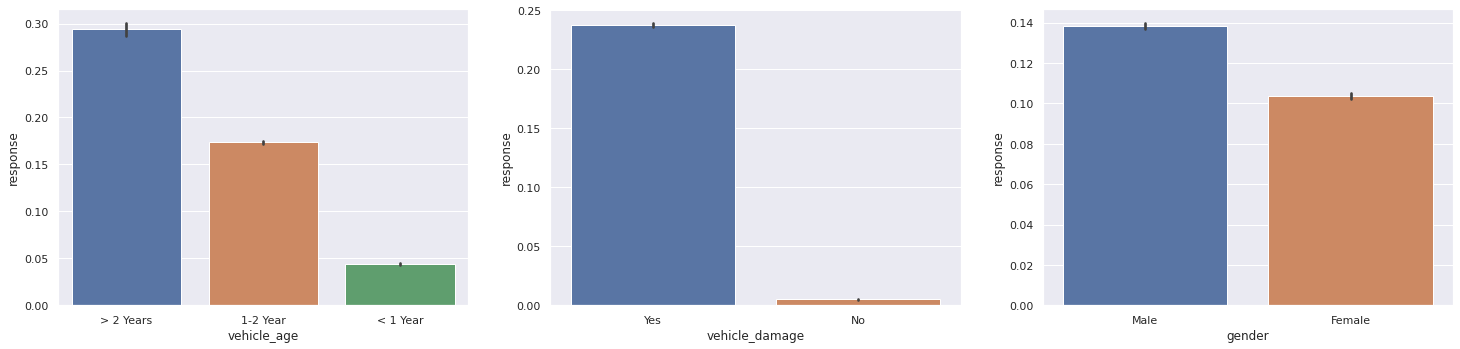

In [15]:
plt.subplot(2,3,1)
sns.barplot(x='vehicle_age',y='response',data=df_raw)

plt.subplot(2,3,2)
sns.barplot(x='vehicle_damage',y='response',data=df_raw)

plt.subplot(2,3,3)
sns.barplot(x='gender',y='response',data=df_raw)

# 3 FEATURE ENGINEERING

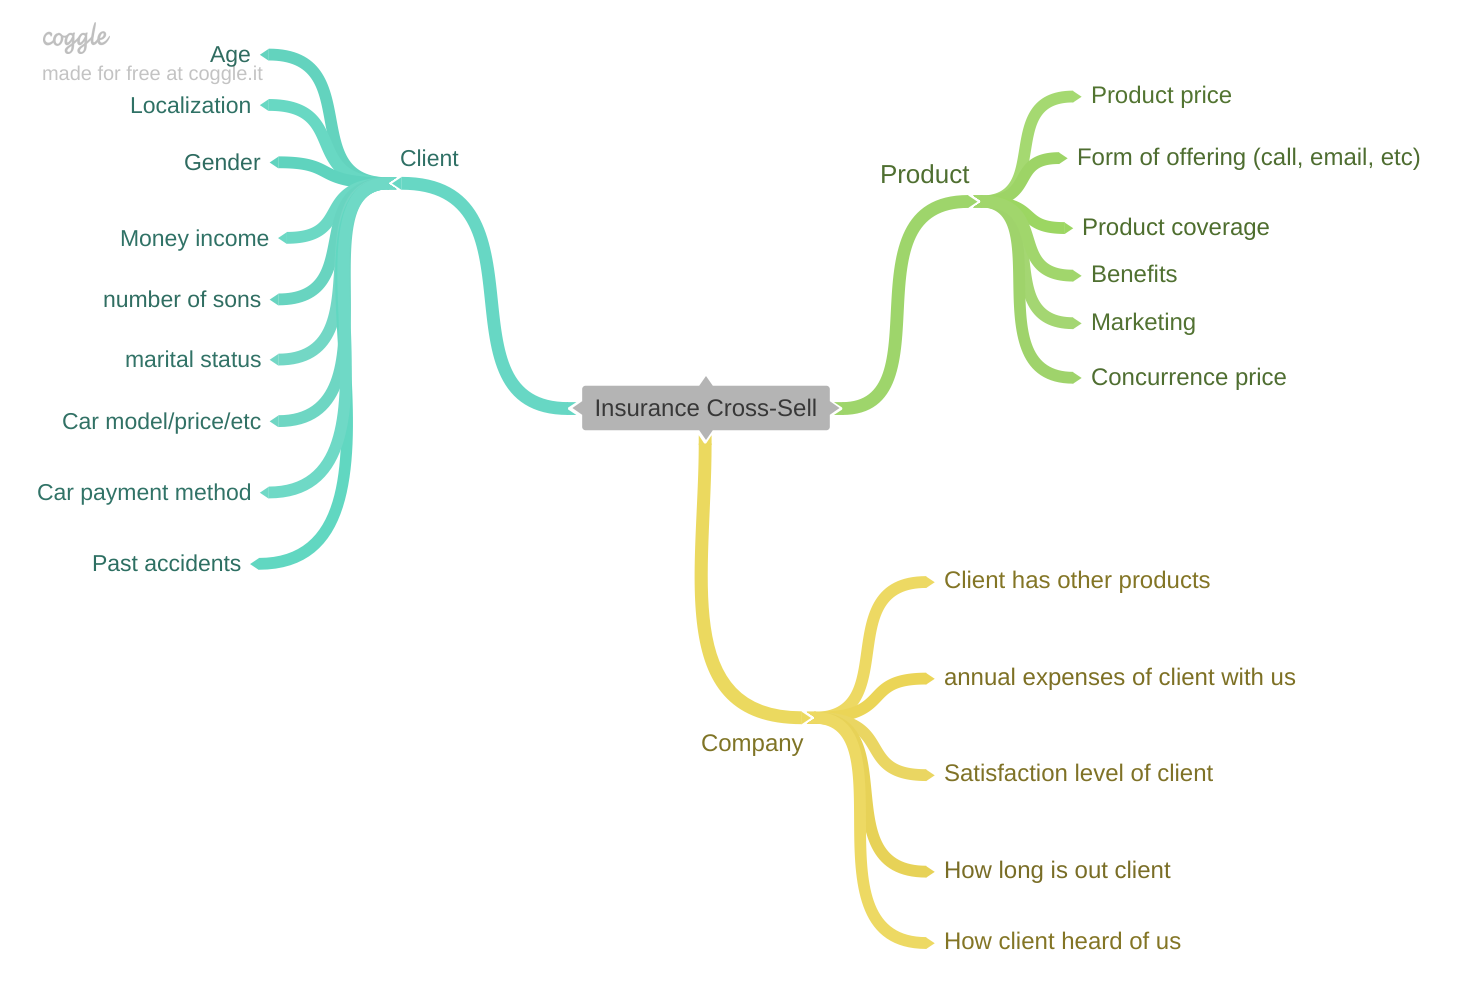

In [16]:
Image('../image/Insurance_Cross-Sell.png')

## 3.1 Business Hypothesis

In [17]:
df_raw

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,"40,454.00",217,1,Male,44,28.00,26.00,1,> 2 Years,Yes
1,2,0,"33,536.00",183,0,Male,76,3.00,26.00,1,1-2 Year,No
2,3,0,"38,294.00",27,1,Male,47,28.00,26.00,1,> 2 Years,Yes
3,4,1,"28,619.00",203,0,Male,21,11.00,152.00,1,< 1 Year,No
4,5,1,"27,496.00",39,0,Female,29,41.00,152.00,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,"30,170.00",88,0,Male,74,26.00,26.00,1,1-2 Year,No
381105,381106,1,"40,016.00",131,0,Male,30,37.00,152.00,1,< 1 Year,No
381106,381107,1,"35,118.00",161,0,Male,21,30.00,160.00,1,< 1 Year,No
381107,381108,0,"44,617.00",74,0,Female,68,14.00,124.00,1,> 2 Years,Yes


I will answer the following hypothesis, since they are what I have enough information for answering:

- Customers with vehicle insurance should be less likely to get want our product;
- There should be few policy sales channel that works really well;
- Older people should want more insurance;
- Older clients should accept more the new insurance;
- People without drivers license should not want insurance at all.
- Lower annual premium prices should increase the chance of selling the new product.
- Females should want less insurance than male clients;
- People with older vehicles should want the insurance more.

## 3.2 Feature Engineering

The data set I am working with is very straightforward in this sense, few information can be derived from tha data. For this reason, no new features will be engineered.

# 4 VARIABLES FILTERING

## 4.1 Rows Filter


There is no client that I need to remove from my base for now. (Check section <b> 6 - DATA PREPARATION </b> for data balance)

## 4.2 Columns Selection

The columns in the current dataset don't lead to any data leakage apparently. So no columns will be filtered out.

# 5 EXPLORATORY DATA ANALYSIS

In [18]:
df5 = df_raw.copy()

In [19]:
df5

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,"40,454.00",217,1,Male,44,28.00,26.00,1,> 2 Years,Yes
1,2,0,"33,536.00",183,0,Male,76,3.00,26.00,1,1-2 Year,No
2,3,0,"38,294.00",27,1,Male,47,28.00,26.00,1,> 2 Years,Yes
3,4,1,"28,619.00",203,0,Male,21,11.00,152.00,1,< 1 Year,No
4,5,1,"27,496.00",39,0,Female,29,41.00,152.00,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,"30,170.00",88,0,Male,74,26.00,26.00,1,1-2 Year,No
381105,381106,1,"40,016.00",131,0,Male,30,37.00,152.00,1,< 1 Year,No
381106,381107,1,"35,118.00",161,0,Male,21,30.00,160.00,1,< 1 Year,No
381107,381108,0,"44,617.00",74,0,Female,68,14.00,124.00,1,> 2 Years,Yes


## 5.1 Univariate Analysis

### 5.1.1 Response Variable

<AxesSubplot:xlabel='response', ylabel='count'>

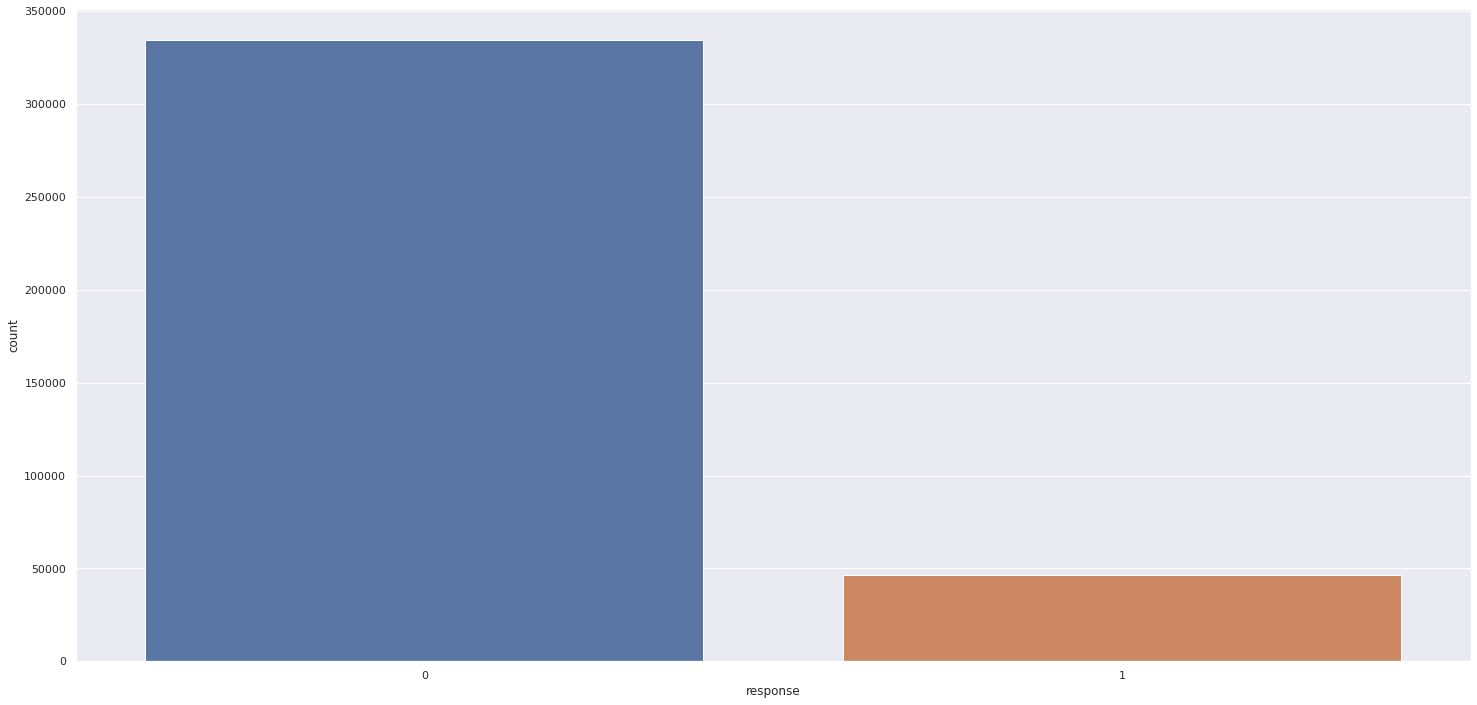

In [20]:
#very unbalanced data, however I could construct a imbalanced model by now and evaluate the need for improvement later


sns.countplot(x='response', data=df5)

### 5.1.2 Numerical Variable

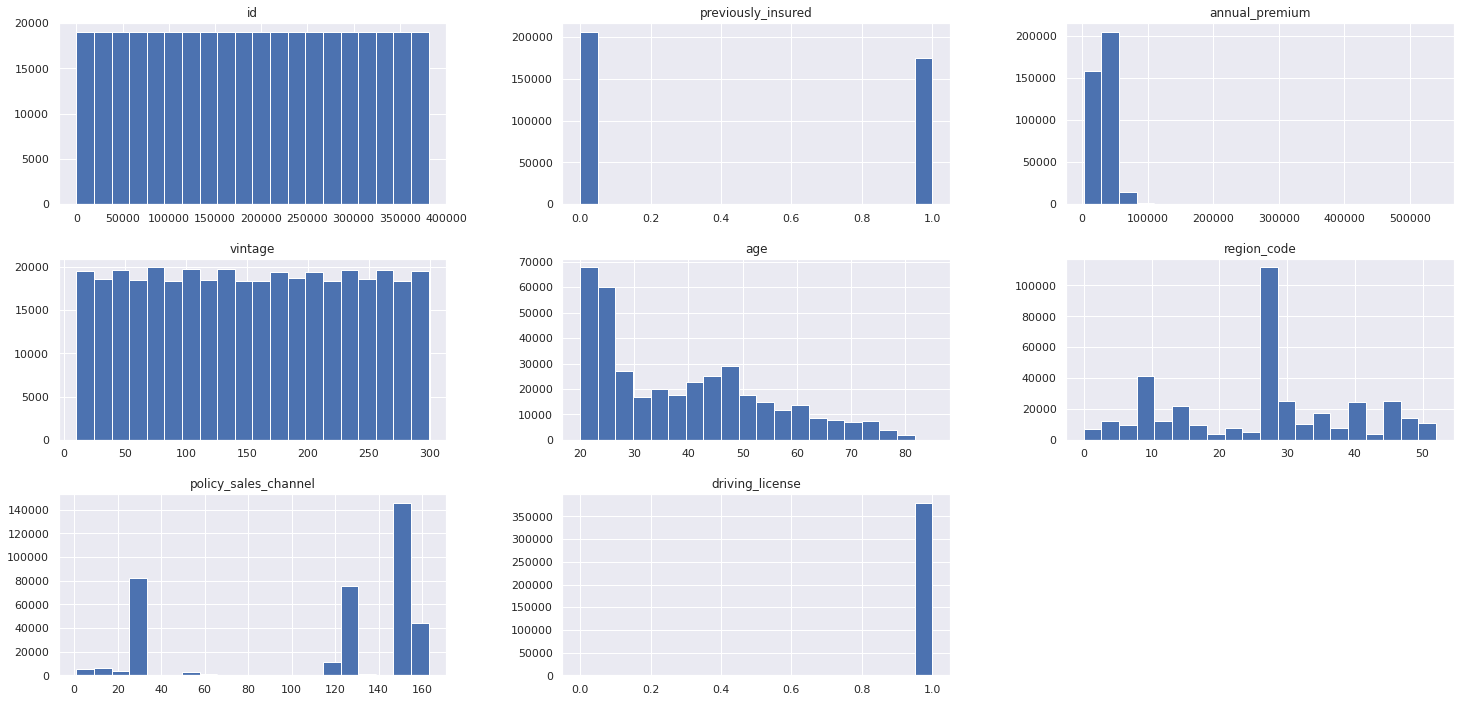

In [21]:
num_attributes = df5.select_dtypes(include=['float64', 'int64']).drop(columns='response')

num_attributes.hist(bins=20);

### 5.1.3 Categorical Variable

In [22]:
cat_attributes = df5[['response','gender', 'vehicle_age', 'vehicle_damage']]

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

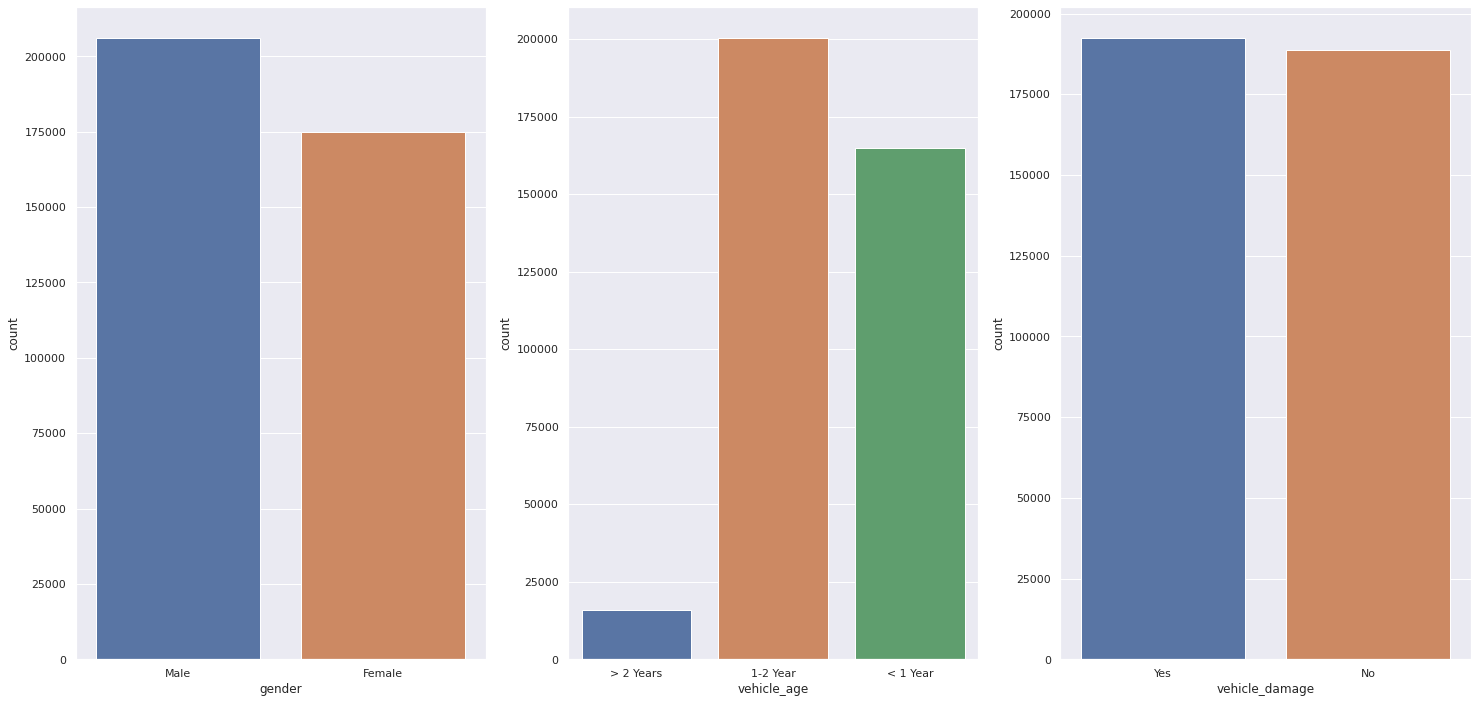

In [23]:
plt.subplot(1,3,1)
sns.countplot(x='gender', data=cat_attributes )

plt.subplot(1,3,2)
sns.countplot(x='vehicle_age', data=cat_attributes )

plt.subplot(1,3,3)
sns.countplot(x='vehicle_damage', data=cat_attributes )

## 5.2 Bivariate Analysis

### Customers with vehicle insurance should be less likely to want our product;
<b>TRUE:</b> Very rarely customers with insurance accept the new one. 

In [24]:
df5[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()

,previously_insured,response
0,0,46552
1,1,158


<AxesSubplot:xlabel='previously_insured', ylabel='response'>

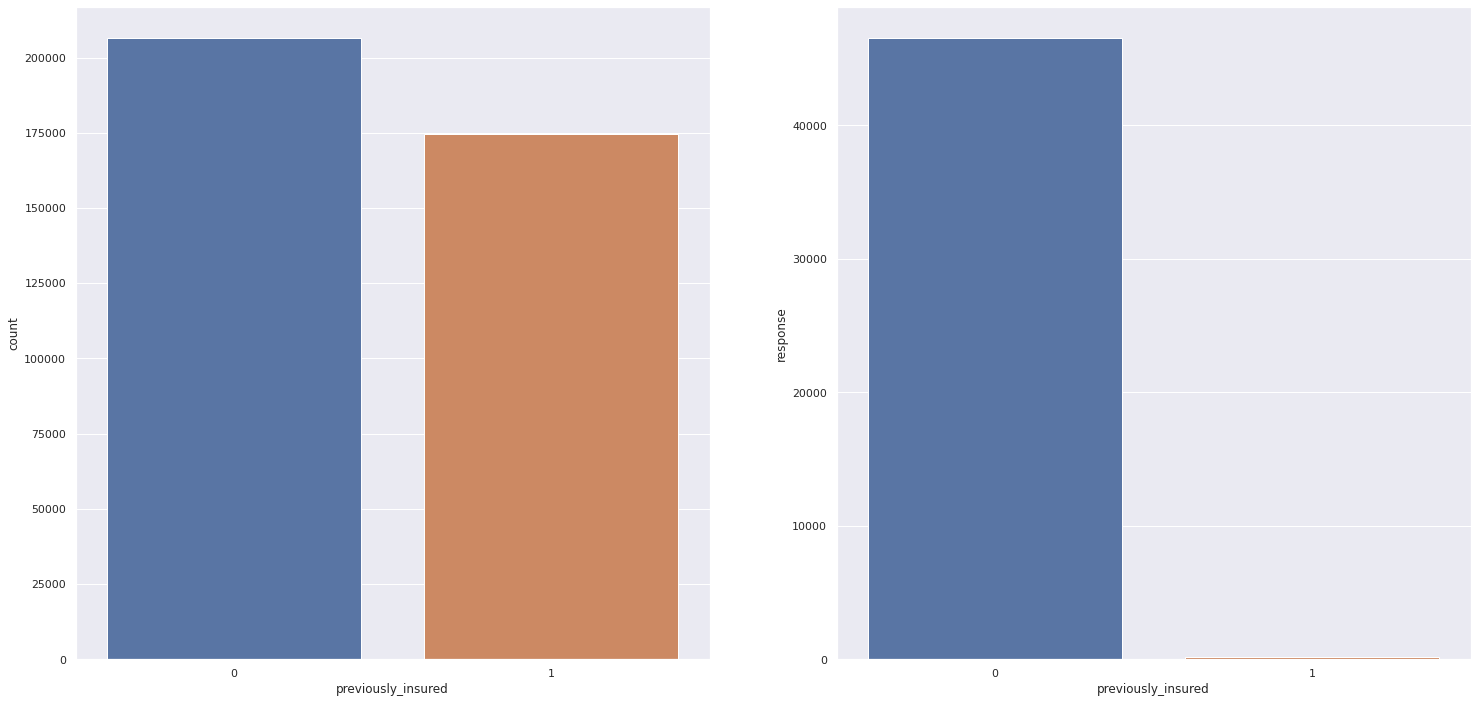

In [25]:
plt.subplot(1,2,1)
sns.countplot(x='previously_insured',data=df5)

plt.subplot(1,2,2)
sns.barplot(x='previously_insured', y='response',data=df5[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index())

Even though there is a good distribution between previously insured and not previously insured, the ones who already had insurance almost never pick the new producct.

### There should be few policy sales channel that works really well;
<b>TRUE:</b> Methods 26 and 124 are responsible for 2/3 of acquisitions. But the rate of a significative amount of methods is around 20% conversion.

<AxesSubplot:xlabel='policy_sales_channel', ylabel='response'>

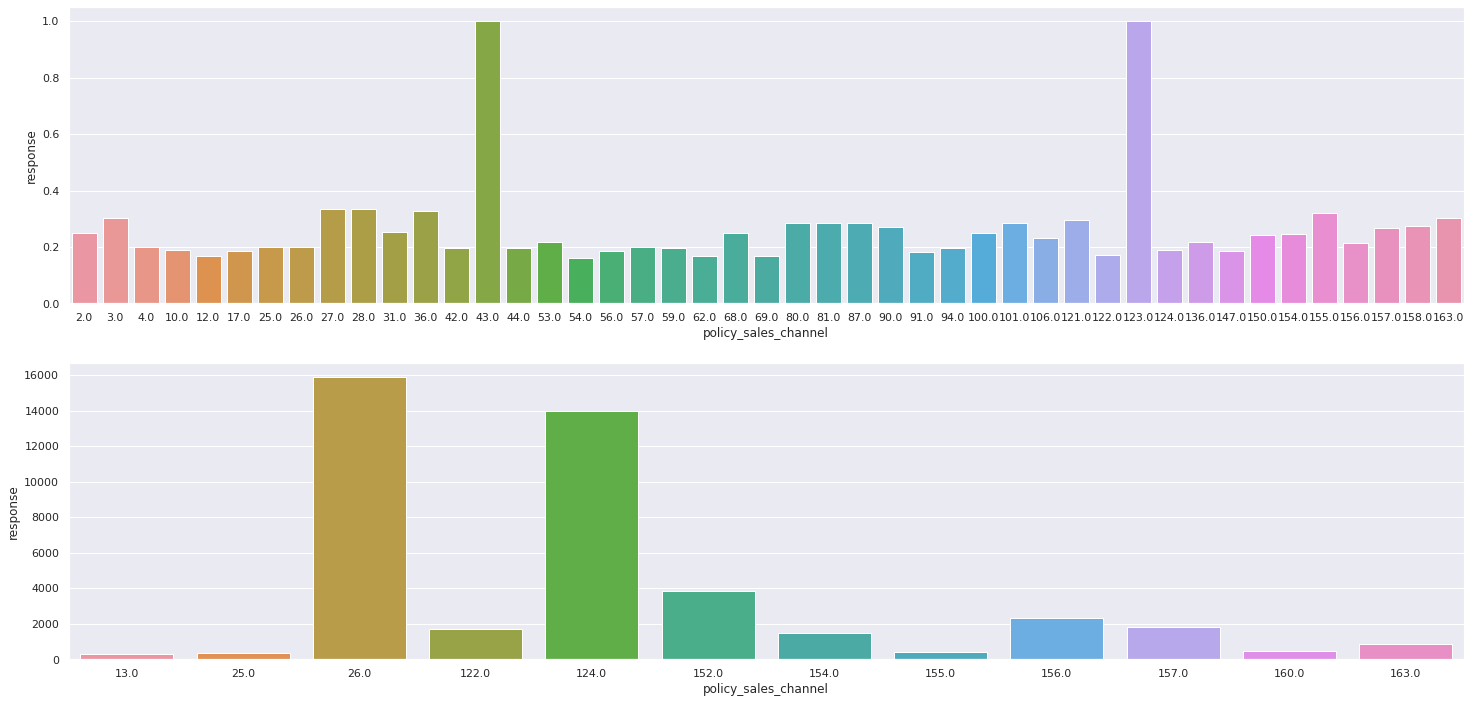

In [26]:
aux1 = df5[['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().reset_index()
aux2 = df5[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

aux1 = aux1[aux1['response'] > 0.15]
aux2 = aux2[aux2['response'] > 200]

plt.subplot(2,1,1)
sns.barplot(x='policy_sales_channel',y='response',data=aux1)

plt.subplot(2,1,2)
sns.barplot(x='policy_sales_channel',y='response',data=aux2)

#We disconsider the importance of the outliars because they are represented by only of sample

### Older people should want more insurance;
<b>FALSE:</b> The peak of desire for insurance is in the range of 30 to 50 years

<AxesSubplot:xlabel='age', ylabel='response'>

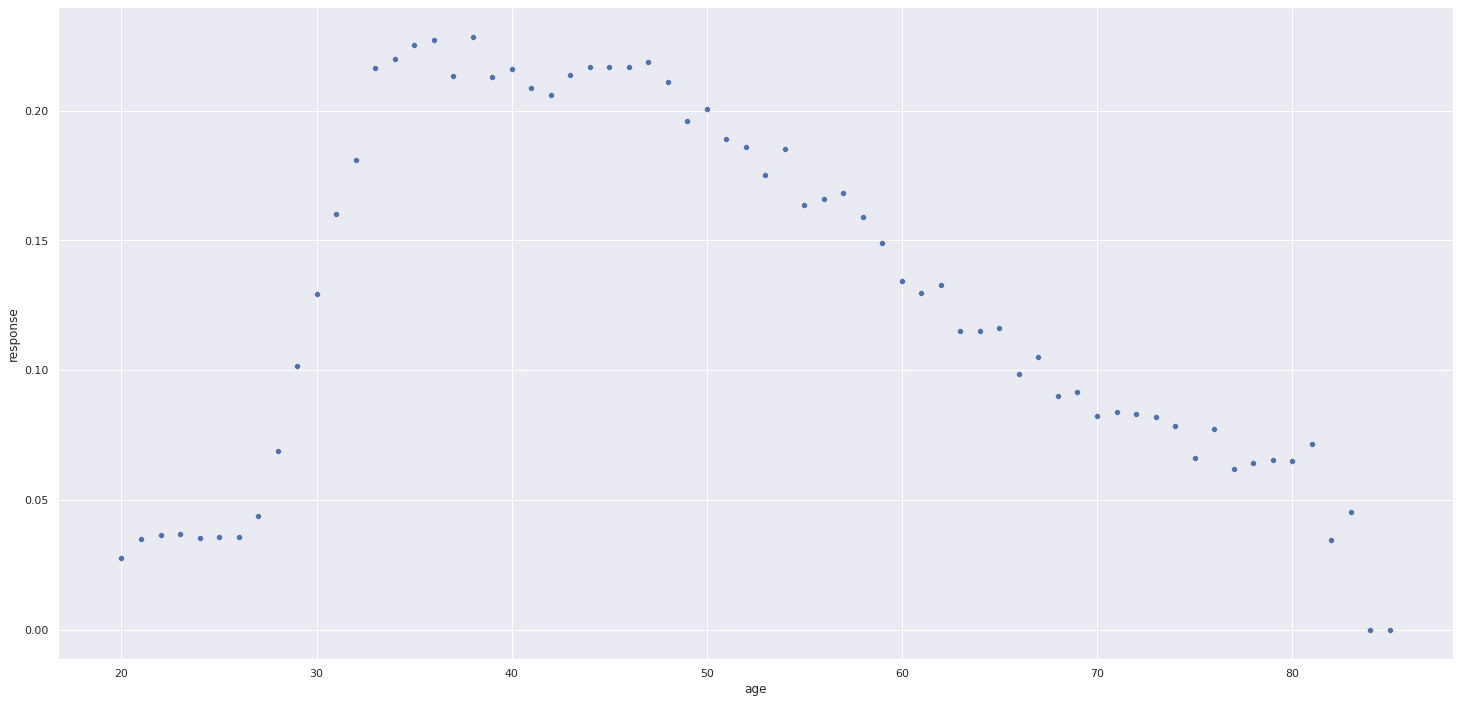

In [27]:
aux1 = df5[['age', 'response']].groupby('age').mean().reset_index()

sns.scatterplot(x='age',y='response',data=aux1)

### People without drivers license should not want insurance at all.
<b>FALSE:</b> The chance of someone not wanting the insurance is divided by ~half when the person doesn't have driving license.

<AxesSubplot:xlabel='driving_license', ylabel='response'>

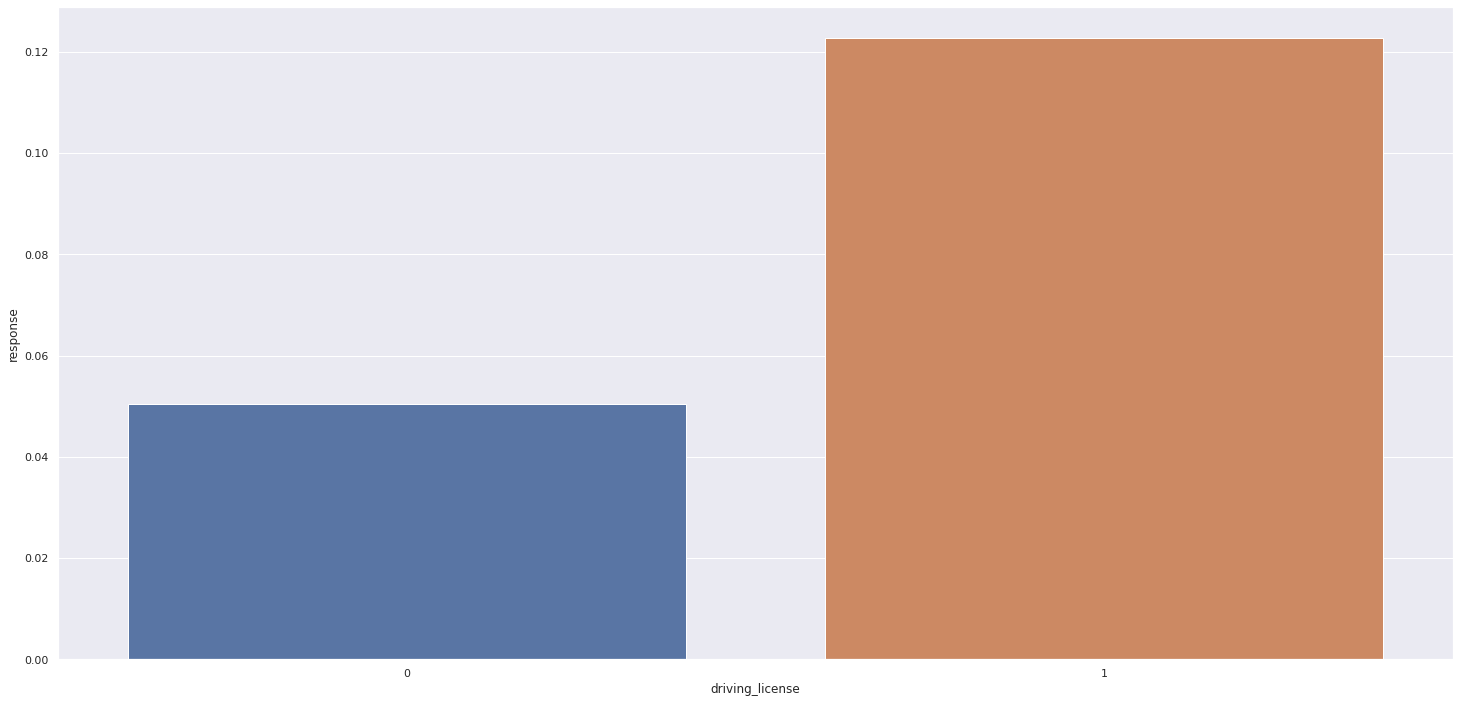

In [28]:
sns.barplot(x='driving_license', y='response',data=df5[['driving_license','response']].groupby('driving_license').mean().reset_index())

### Lower annual premium prices should increase the chance of selling the new product.
<b>FALSE:</b> After about 30,000 annual premium, the aderence is pretty even among prices,

<AxesSubplot:xlabel='annual_premium_binned', ylabel='response'>

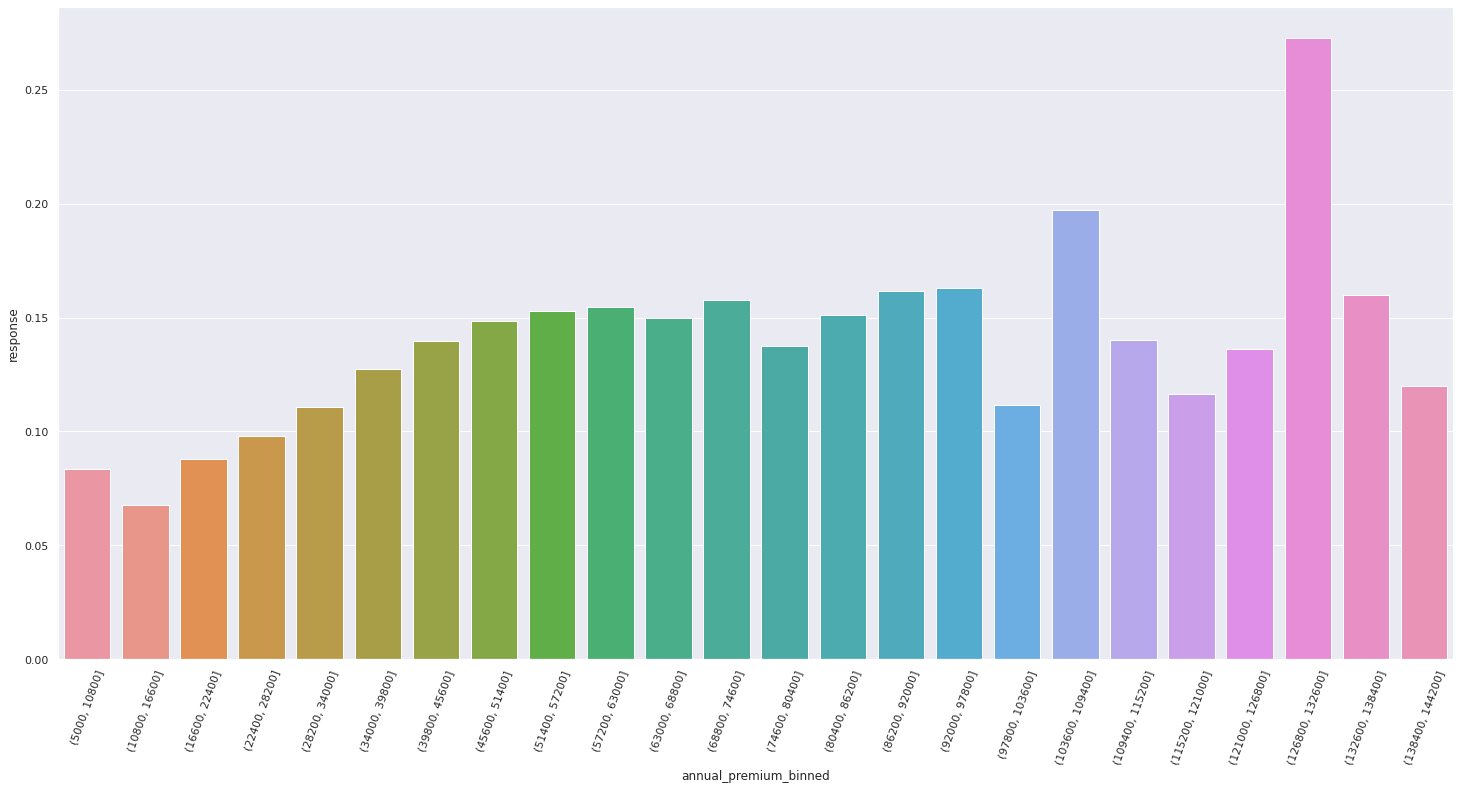

In [29]:
bins = list( np.arange(5000,150000, int((150000-5000)/25) ) )
aux1 = df5[['annual_premium', 'response']].copy()
aux1['annual_premium_binned'] = pd.cut( aux1['annual_premium'], bins=bins )
aux1 = aux1.groupby('annual_premium_binned').mean().reset_index() # using sum because there are few samples in higher values of annual_premium
plt.xticks(rotation=70)

sns.barplot(x='annual_premium_binned',y='response',data=aux1)

### Females should want less insurance than male clients;
<b>TRUE:</b> Men buy more insurance than women.

<AxesSubplot:xlabel='gender', ylabel='response'>

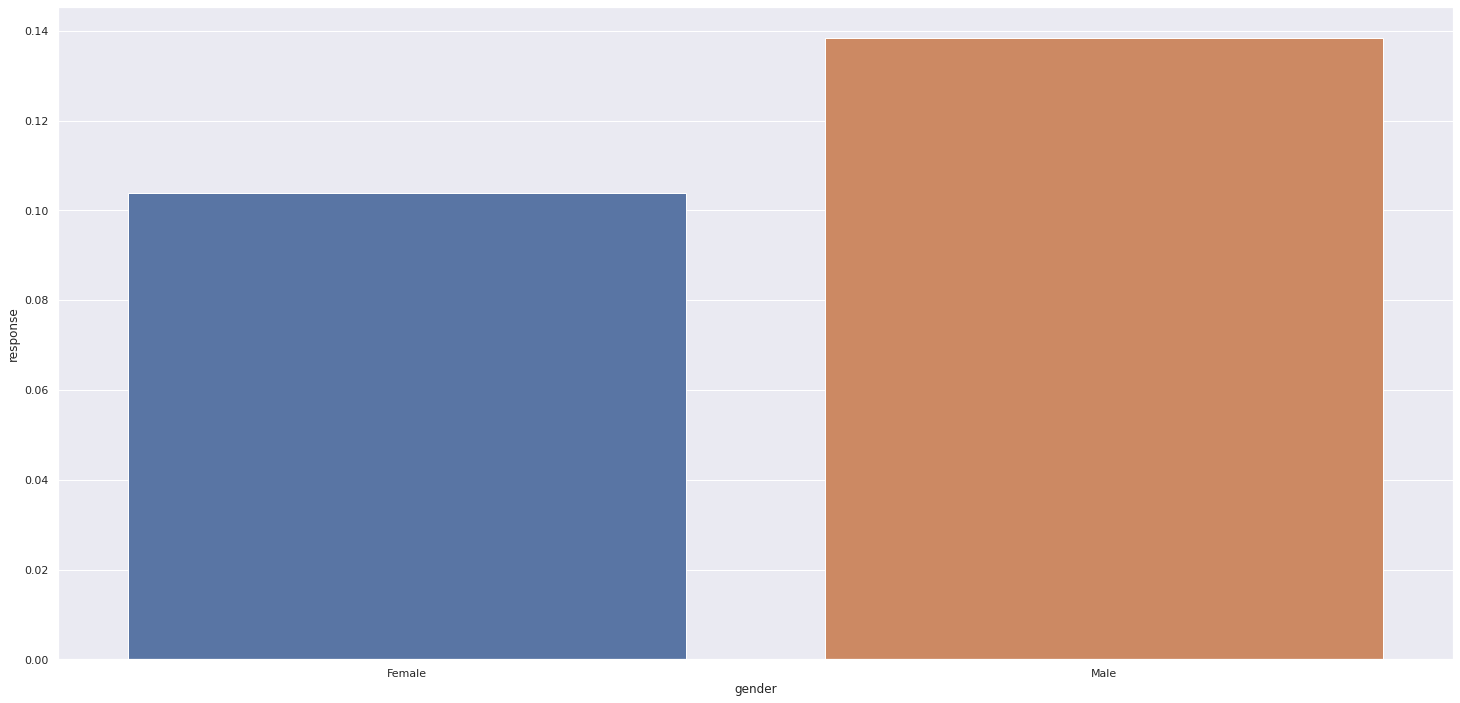

In [30]:
aux1 = df5[['gender','response']].groupby('gender').mean().reset_index()

sns.barplot(x='gender', y='response',data=aux1)

### People with older vehicles should want the insurance more.
<b>True:</b> Older cars imply more insurance buy

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

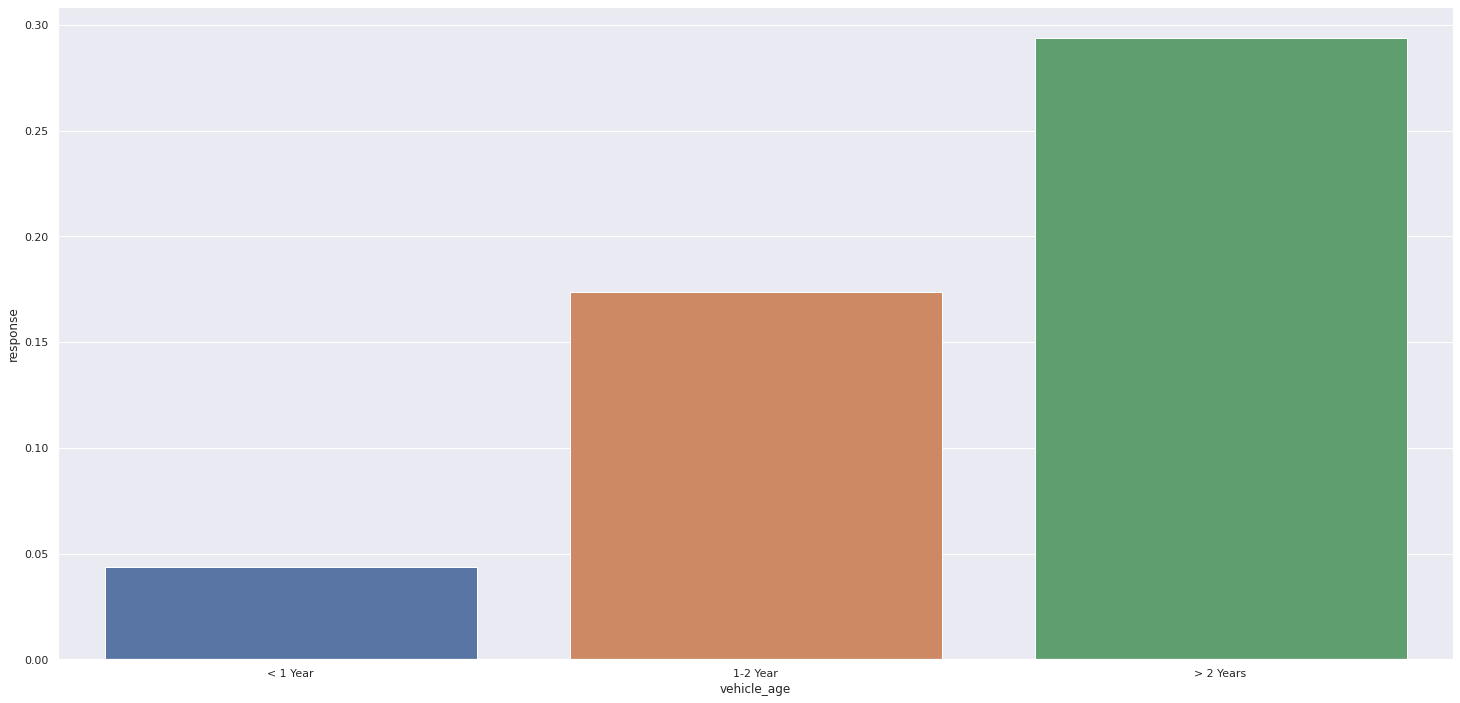

In [31]:
aux1 = df5[['vehicle_age','response']].groupby('vehicle_age').mean().reset_index()
aux1['vehicle_age'] = pd.Categorical(aux1['vehicle_age'], categories=['< 1 Year','1-2 Year', '> 2 Years' ], ordered=True)

sns.barplot(x='vehicle_age',y='response',data=aux1)

### There are certain regions that are more likely to buy our insurance
<b>TRUE:</b> More than half of our buyers come from one single region. 

<AxesSubplot:xlabel='region_code', ylabel='response'>

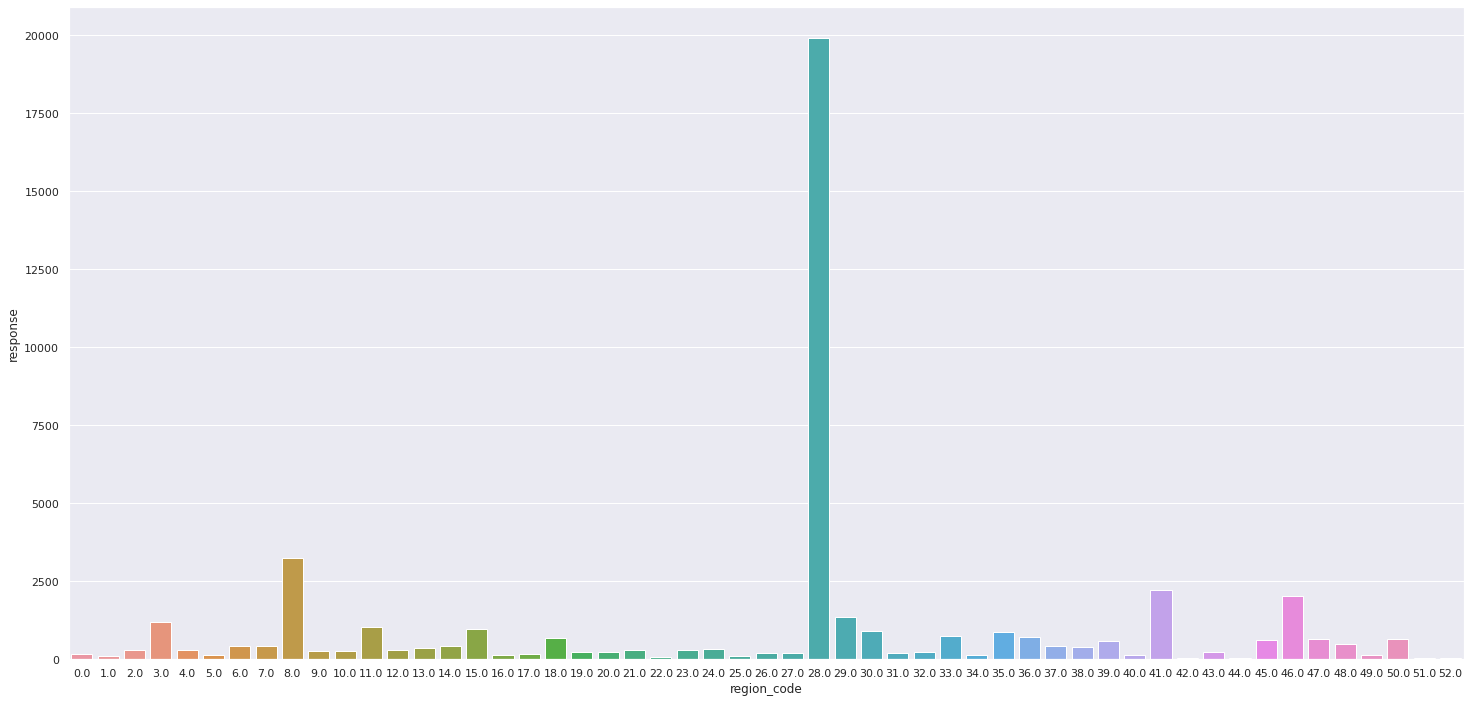

In [32]:
aux1 = df5[['response', 'region_code']].groupby('region_code').sum().reset_index()

sns.barplot(x='region_code',y='response',data=aux1)

<AxesSubplot:xlabel='region_code', ylabel='response'>

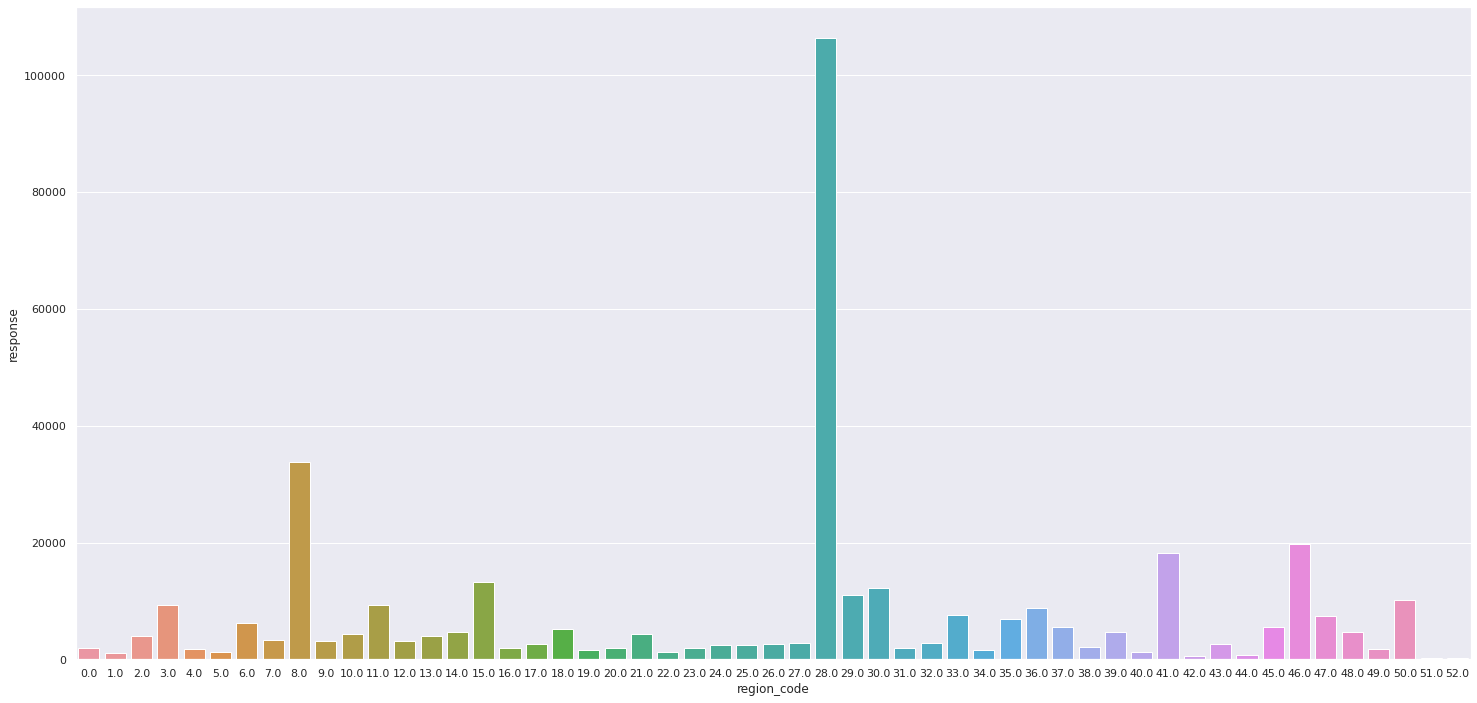

In [33]:
sns.barplot(x='region_code',y='response', data=df5[['response', 'region_code']].groupby('region_code').count().reset_index())

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Attributes

<AxesSubplot:>

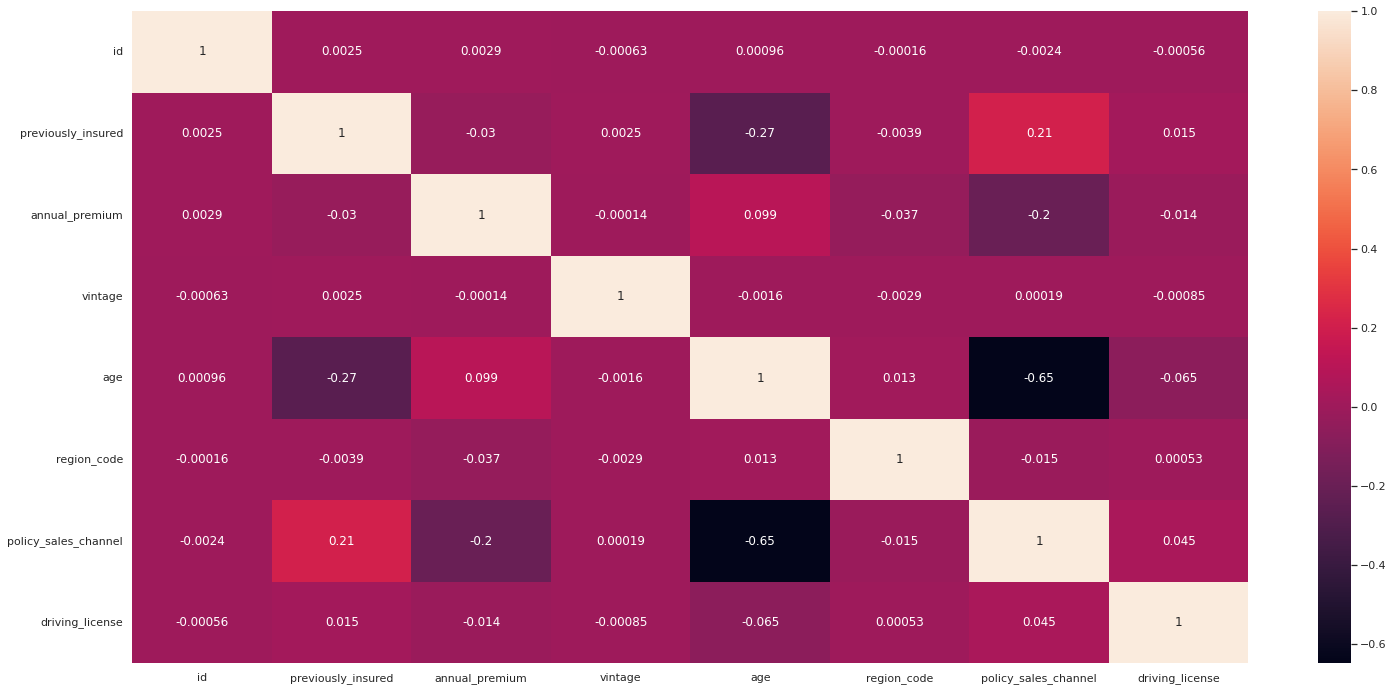

In [34]:
sns.heatmap(num_attributes.corr(method='spearman'), annot=True)

### 5.3.2 Categorical Attributes

<AxesSubplot:>

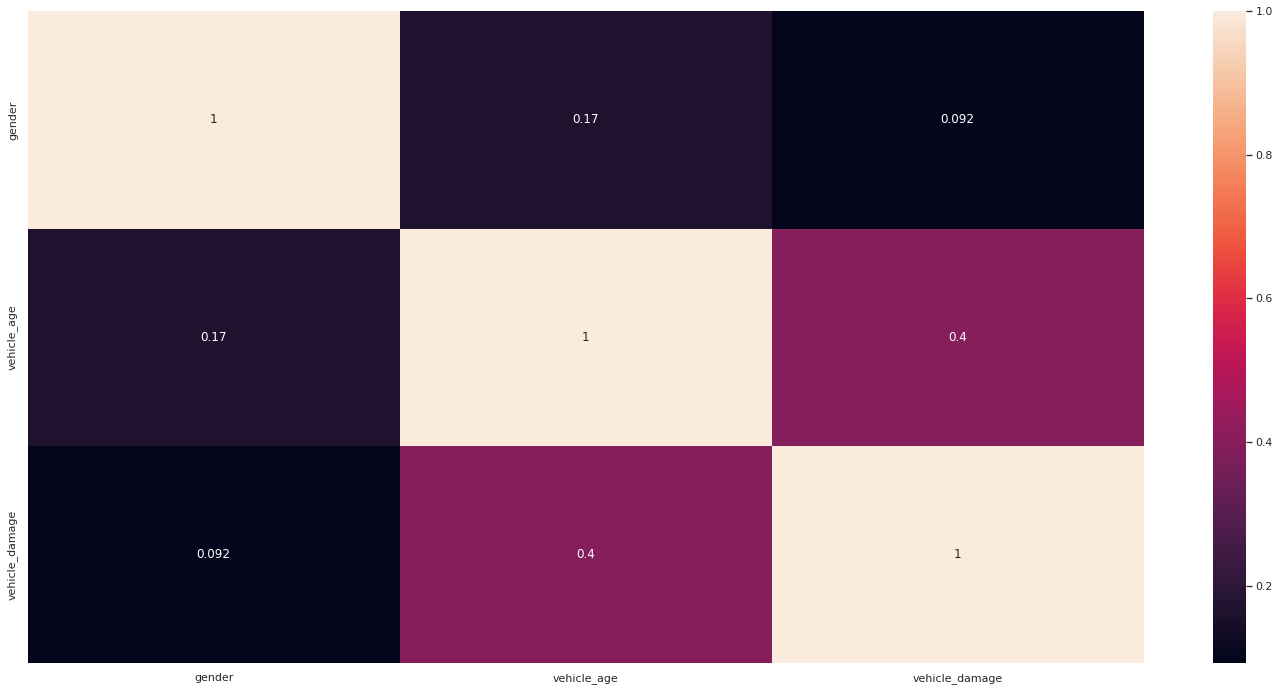

In [35]:
cat_columns = cat_attributes.drop(columns='response').columns

cat_heatmap_dict = {}

for col1 in cat_columns:
    cat_heatmap_dict[col1] = []
    for col2 in cat_columns:
        corr_value = cramer_v(cat_attributes[col1], cat_attributes[col2] )
        cat_heatmap_dict[col1].append(corr_value)
        
cat_corr_heatmap_df = pd.DataFrame(cat_heatmap_dict)
cat_corr_heatmap_df = cat_corr_heatmap_df.set_index( cat_corr_heatmap_df.columns )

sns.heatmap(cat_corr_heatmap_df, annot=True)

# 6 DATA PREPARATION

In [36]:
df6 = df5.drop(columns='id').copy()

## 6.1 Normalization

No variables are normally distributed, therefore no normalization will be done

## 6.2 Rescaling

<AxesSubplot:ylabel='age'>

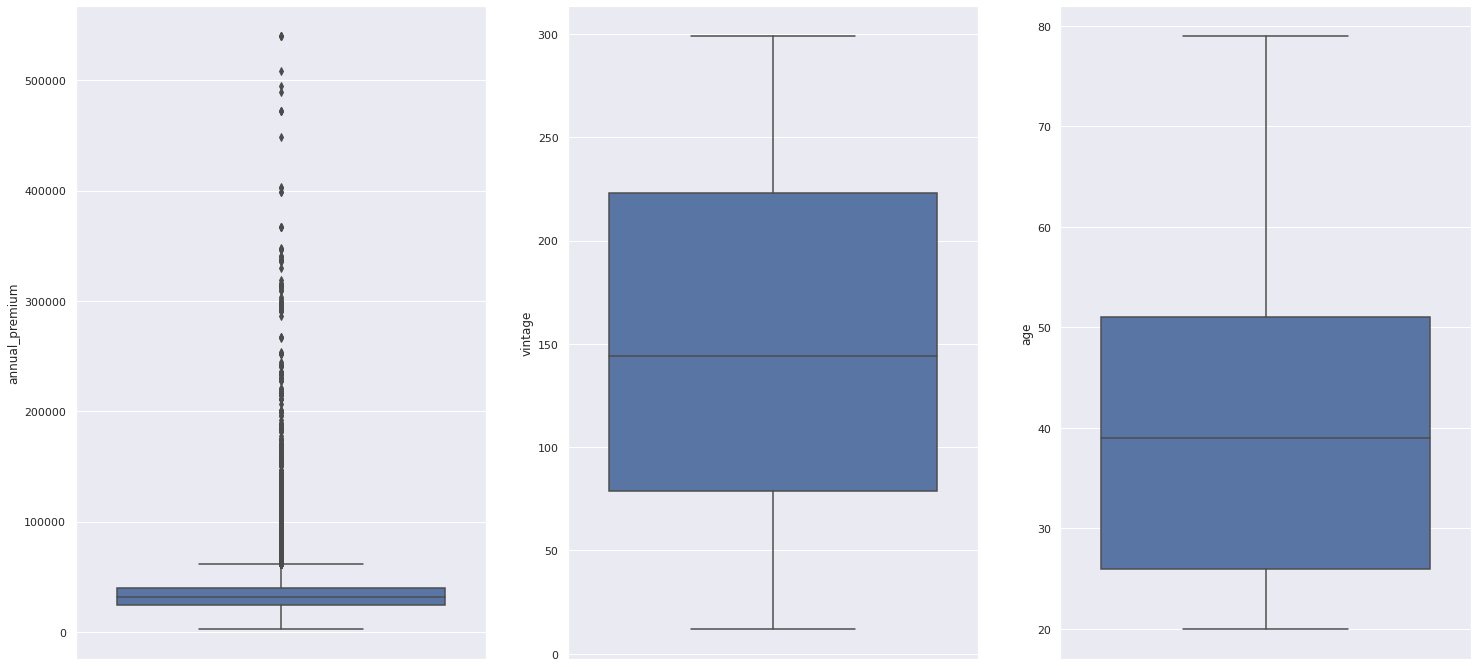

In [37]:
plt.subplot(1,3,1)

sns.boxplot(y=df6['annual_premium'], data=df6['annual_premium']) #Only annual premium needs robust scaler, due to outliers

plt.subplot(1,3,2)

sns.boxplot(y=df6['vintage'], data=df6['vintage'])

plt.subplot(1,3,3)

sns.boxplot(y=df6['age'], data=df6['age'])

In [38]:
rs = RobustScaler()
mms = MinMaxScaler()

df6['annual_premium'] = rs.fit_transform( df6[['annual_premium']] )
df6['vintage'] = mms.fit_transform( df6[['vintage']] )
df6['age'] = mms.fit_transform( df6[['age']] )

## 6.3 Transformation

### 6.3.1 Encoding

In [39]:
#Those are the features that need encoding:
# 'gender' -> binary encoding (because only two values)
# 'vehicle_damage' -> binary encoding (because only two values)
# 'vehicle_age' -> label encoder (there is a meaning of progression)
# 'region_code' -> frequency encoding (There are regions that have much more clients, it could be represented by a frequency encoding)
# 'policy_sales_channel' -> frequency encoding(There are policies that reach  many more clients)



df6['gender'] = df6[['gender']].apply(lambda x: 1 if x['gender'] == 'Female' else 0, axis=1)
df6['vehicle_damage'] = df6[['vehicle_damage']].apply(lambda x: 1 if x['vehicle_damage'] == 'Yes' else 0, axis=1)

map_vehicle_age = {'< 1 Year':0,
                   '1-2 Year':1,
                   '> 2 Years':2}
df6['vehicle_age'] = df6['vehicle_age'].map(map_vehicle_age)

df6['region_code'] = freq_encoder(df6[['region_code']])
df6['policy_sales_channel'] = freq_encoder(df6[['policy_sales_channel']])

### 6.3.2 Response Variable Balancing

I am choosing to not do it now, I will test later if the accuracy is too bad

# 7 FEATURE SELECTION

In [40]:
df7 = df6.copy()

## 7.1 Split dataframe into training and test dataset

In [41]:
X = df7.drop(columns='response').copy()
y = df7['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## 7.2 Selecting Features with Extra Trees

In [45]:
etc_model = en.ExtraTreesClassifier(n_estimators=100,
                                   max_depth=30,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=42
                                   ).fit(x_train, y_train)

In [63]:
df_feat_importance = pd.DataFrame(columns= ['feature','importance'])

for num in range(len(x_train.columns)):
    df_feat_importance = df_feat_importance.append({'feature':x_train.columns[num],
                               'importance':etc_model.feature_importances_[num]}, ignore_index=True)

In [69]:
aux1 = df_feat_importance.sort_values('importance', ascending=False)

aux1[aux1['importance'] > 0.05]['feature'].tolist()

['vintage',
 'annual_premium',
 'age',
 'region_code',
 'vehicle_damage',
 'policy_sales_channel',
 'previously_insured']

## 7.3 Manual Feature Selection

In [70]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']

# 8 MACHINE LEARNING MODELLING

In [72]:
x_train = x_train[cols_selected]
x_test = x_test[cols_selected]

## 8.1 Average Model

## 8.2 Linear Regression Model

### 8.2.1 Linear Regression Model - Cross Validation

## 8.3 Linear Regression Regularized Model - Lasso

###  8.3.1 Lasso - Cross Validation

## 8.4 Random Forest Regressor

### 8.4.1 Random Forest Regressor - Cross Validation

## 8.5 XGBoost Regressor

### 8.5.1 XGBoost Regressor - Cross Validation

## 8.6 Compare Model's Performance

### 8.6.1 Single Performance

### 8.6.2 Real Performance - Cross Validation

# 9 HYPERPARAMETER FINE TUNING

## 9.1 Random Search

## 9.2 Final Model

# 10 TRADUCAO E INTERPRETACAO DO ERRO

## 10.1 Business Performance

## 10.2 Total Performance

## 10.3 Machine Learning Performance

# 11 DEPLOY MODEL TO PRODUCTION

## 11.1 Rossmann Class

## 11.2 API Handler

## 11.3 API Tester